# **Digit Recognizer**

# Import necessary Libraries

In [18]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import os
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
torch.manual_seed(42)

# Data Preprocessing

In [19]:
data = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
test = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")

In [20]:
data_np = data.to_numpy()
x = data_np[:,1:].reshape(-1, 28, 28)  #reshape the input to (28, 28)
y = data_np[:0]

test_data = test.to_numpy()
x_test = test_data.reshape(-1, 28, 28)

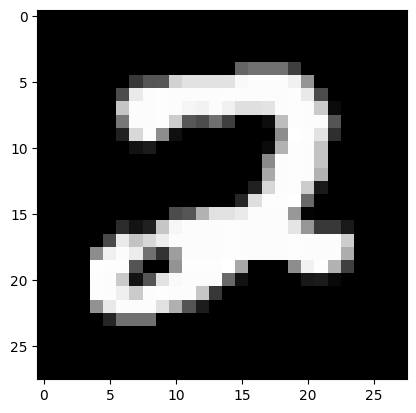

In [21]:
# Example of one data from data
plt.imshow(x[169], cmap='gray')

In [22]:
# Custom PyTorch Dataset for loading grayscale digit images and their labels

class CustomDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.labels = self.data['label'].values
        self.images = self.data.drop(columns=['label']).values.reshape(-1, 28, 28).astype("float32")
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img = self.images[idx]
        label = self.labels[idx]
        img = img.astype("uint8")
        img = Image.fromarray(img)
        if self.transform:
            img = self.transform(img)
        return img, label

In [23]:
transformm = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [24]:
dataset = CustomDataset(data, transform = transformm)

# Training the model

In [25]:
# Split the data into training and Validation set

train_size = int(0.8 * len(dataset))
valid_size = len(dataset) - train_size
train_dataset, valid_dataset = random_split(dataset, [train_size, valid_size])

train_ = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_ = DataLoader(valid_dataset, batch_size=64, shuffle=False)

In [26]:
# Simple CNN model for Classifing handwritten digit classification (0–9)

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.relu1 = nn.ReLU()
        self.max_pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.relu2 = nn.ReLU()
        self.max_pool2 = nn.MaxPool2d(2)
        self.conv3 = nn.Conv2d(32, 32, 3, padding=1)
        self.relu3 = nn.ReLU()
        self.max_pool3 = nn.MaxPool2d(2)
        self.conv4 = nn.Conv2d(32, 16, 3, padding=1)
        self.relu4 = nn.ReLU()
        self.max_pool4 = nn.MaxPool2d(2)
        self.ada_max_pool5 = nn.AdaptiveAvgPool2d(1)
        self.flatten5 = nn.Flatten()
        self.linear5 = nn.Linear(16, 10)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.max_pool1(self.relu1(self.conv1(x)))
        x = self.max_pool2(self.relu2(self.conv2(x)))
        x = self.max_pool3(self.relu3(self.conv3(x)))
        x = self.max_pool4(self.relu4(self.conv4(x)))
        x = self.ada_max_pool5(x)
        x = self.flatten5(x)
        x = self.linear5(x)
        x = self.softmax(x)
        return x

In [30]:
# Custom training framework for the digit recognizer CNN with evaluation and prediction utilities

class SimpleCNN_net:
    def __init__(self, model, train_dl, valid_dl, lr=0.001, weight_decay=0.0005):
        self.model = model
        self.train_dl = train_dl
        self.valid_dl = valid_dl
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr, weight_decay=weight_decay)
        self.loss_fn = nn.CrossEntropyLoss()

    def train(self, epochs=10):
        history = {"train_loss": [], "valid_loss": []} 
        for epoch in range(epochs):
            self.model.train()
            train_loss, train_preds, train_labels = 0, [], []
            for x, y in self.train_dl:
                self.optimizer.zero_grad()
                out = self.model(x)
                loss = self.loss_fn(out, y)
                loss.backward()
                self.optimizer.step()
                train_loss += loss.item()
                train_preds.extend(out.argmax(1).numpy())
                train_labels.extend(y.numpy())
            train_loss /= len(self.train_dl)
            train_acc = accuracy_score(train_labels, train_preds)
            
            self.model.eval()
            valid_loss, valid_preds, valid_labels = 0, [], []
            with torch.no_grad():
                for x, y in self.valid_dl:
                    out = self.model(x)
                    loss = self.loss_fn(out, y)
                    valid_loss += loss.item()
                    valid_preds.extend(out.argmax(1))
                    valid_labels.extend(y)
            valid_loss /= len(self.valid_dl)
            valid_acc = accuracy_score(torch.tensor(valid_preds), torch.tensor(valid_labels))

            history["train_loss"].append(train_loss)
            history["valid_loss"].append(valid_loss)
            print(f"Epoch {epoch+1}: "
                  f"Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}, "
                  f"Valid Loss={valid_loss:.4f}, Valid Acc={valid_acc:.4f}")
        plt.plot(history["train_loss"], label="Train Loss")
        plt.plot(history["valid_loss"], label="Valid Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.title("Training vs Validation Loss")
        plt.show()
            
    def predict(self, x, sub):
        self.model.eval()
        with torch.no_grad():
            for i in range(x.shape[0]):
                img = x[i]
                img = torch.tensor(img, dtype=torch.float32)
                img = img.unsqueeze(0).unsqueeze(0)
                output = self.model(img)
                pred_class = output.argmax(dim=1).item()
                sub[i] = pred_class
        return sub

In [31]:
archi = SimpleCNN()
model = SimpleCNN_net(archi, train_, valid_)

Epoch 1: Train Loss=1.5682, Train Acc=0.8996, Valid Loss=1.5070, Valid Acc=0.9590
Epoch 2: Train Loss=1.5051, Train Acc=0.9605, Valid Loss=1.4983, Valid Acc=0.9662
Epoch 3: Train Loss=1.4955, Train Acc=0.9697, Valid Loss=1.5002, Valid Acc=0.9639
Epoch 4: Train Loss=1.4924, Train Acc=0.9725, Valid Loss=1.4947, Valid Acc=0.9707
Epoch 5: Train Loss=1.4897, Train Acc=0.9745, Valid Loss=1.4898, Valid Acc=0.9748
Epoch 6: Train Loss=1.4887, Train Acc=0.9754, Valid Loss=1.4923, Valid Acc=0.9711
Epoch 7: Train Loss=1.4863, Train Acc=0.9777, Valid Loss=1.4865, Valid Acc=0.9771
Epoch 8: Train Loss=1.4848, Train Acc=0.9794, Valid Loss=1.4863, Valid Acc=0.9786
Epoch 9: Train Loss=1.4825, Train Acc=0.9818, Valid Loss=1.4886, Valid Acc=0.9751
Epoch 10: Train Loss=1.4822, Train Acc=0.9819, Valid Loss=1.4868, Valid Acc=0.9775
Epoch 11: Train Loss=1.4819, Train Acc=0.9821, Valid Loss=1.4852, Valid Acc=0.9782
Epoch 12: Train Loss=1.4813, Train Acc=0.9826, Valid Loss=1.4842, Valid Acc=0.9793
Epoch 13: Tra

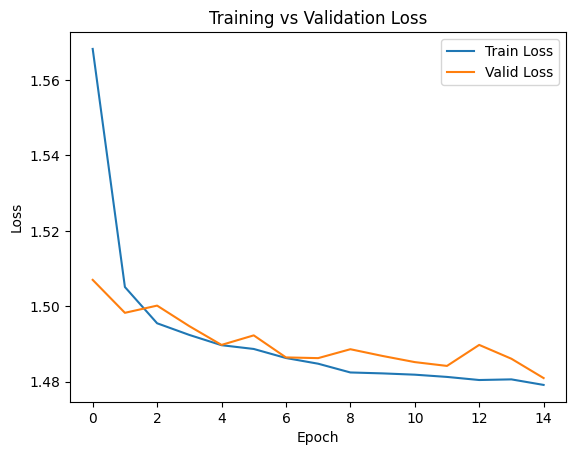

In [33]:
model.train(epochs = 15)

In [34]:
submission = np.zeros(x_test.shape[0])
submission = model.predict(x_test, submission)

# Some sample examples

label : 2.0


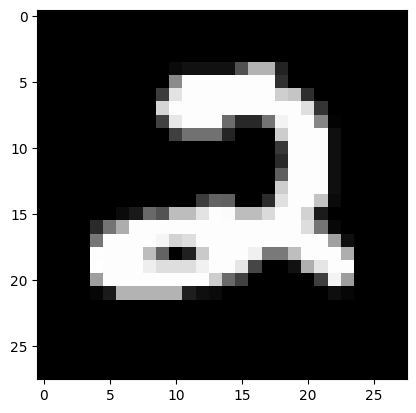

In [35]:
plt.imshow(x_test[0], cmap='gray')
print(f"label : {submission[0]}")

label : 5.0


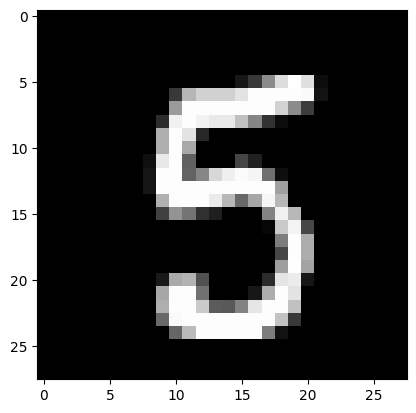

In [36]:
plt.imshow(x_test[10], cmap='gray')
print(f"label : {submission[10]}")

label : 1.0


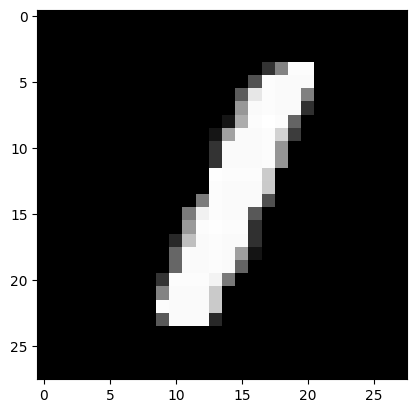

In [37]:
plt.imshow(x_test[69], cmap='gray')
print(f"label : {submission[69]}")